# maxvogt-analysis: Thalwil

The code in this notebook is based on [Martin Fleischmann's](https://martinfleischmann.net/) 2021 workshop [*Capturing the Structure of Cities with Data Science (SDSC)*](https://github.com/martinfleis/sdsc21-workshop), licensed under the [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/). © 2021 Martin Fleischmann.

The geodata in this notebook is retrieved from OpenStreetMap. © OpenStreetMap Contributors.

<hr>

This notebook contains geodata and analyses for the following items of the [Max Vogt collection](https://mtwente.github.io/maxvogt/) by Moritz Twente and Luisa Omonsky:
- [TW014](https://mtwente.github.io/maxvogt/items/tw014.html)
- [TW059](https://mtwente.github.io/maxvogt/items/tw059.html)

<hr>

Open in an interactive in-browser environment: 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mtwente/maxvogt-analysis/main?labpath=analysis%2Fthalwil.ipynb)

In [1]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

Pick a place, ideally a town with a good coverage in OpenStreetMap and its local CRS.

In [2]:
place = 'Thalwil'
local_crs = 'EPSG:2056'

In [3]:
geopandas.tools.geocode(place).explore()

## Input data

Download data from OpenStreetMap.

### Buildings

In [4]:
buildings = osmnx.features.features_from_place(place, tags={'building':True})

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/sit

In [5]:
buildings

entrance  \
element_type osmid                 
node         2810439683      NaN   
             3844760994      NaN   
             3844760995      NaN   
             9778986256      yes   
way          23646192        NaN   
...                          ...   
             1261816537      NaN   
             1268087245      NaN   
             1268087246      NaN   
             1278336013      NaN   
relation     13435259        NaN   

                                                                  geometry  \
element_type osmid                                                           
node         2810439683                           POINT (8.56580 47.28415)   
             3844760994                           POINT (8.56203 47.29560)   
             3844760995                           POINT (8.56182 47.29547)   
             9778986256                           POINT (8.56120 47.29869)   
way          23646192    POLYGON ((8.56402 47.29683, 8.56399 47.29681, ...   
...                                                                    ...   
             1261816537  POLYGON ((8.57405 47.28117, 8.57398 47.28115, ...   
             1268087245  POLYGON ((8.56272 47.29618, 8.56284 47.29623, ...   
             1268087246  POLYGON ((8.56284 47.29623, 8.56272 47.29618, ...   
             1278336013  POLYGON ((8.55155 47.27662, 8.55140 47.27636, ...   
relation     13435259    POLYGON ((8.55588 47.29951, 8.55579 47.29964, ...   

                        addr:housenumber          addr:street addr:city  \
element_type osmid                                                        
node         2810439683              NaN                  NaN       NaN   
             3844760994              143     Alte Landstrasse   Thalwil   
             3844760995               12              Hortweg   Thalwil   
             9778986256               43  Ludretikonerstrasse   Thalwil   
way          23646192                 23       Bahnhofstrasse   Thalwil   
...                                  ...                  ...       ...   
             1261816537              NaN                  NaN       NaN   
             1268087245              NaN                  NaN       NaN   
             1268087246              NaN                  NaN       NaN   
             1278336013              NaN                  NaN       NaN   
relation     13435259                 35         Alpenstrasse   Thalwil   

                        addr:country addr:postcode     building  \
element_type osmid                                                
node         2810439683          NaN           NaN       public   
             3844760994          NaN          8800      terrace   
             3844760995          NaN          8800      terrace   
             9778986256          NaN          8800  residential   
way          23646192             CH          8800   commercial   
...                              ...           ...          ...   
             1261816537          NaN           NaN          yes   
             1268087245          NaN           NaN          yes   
             1268087246          NaN           NaN          yes   
             1278336013          NaN           NaN          yes   
relation     13435259            NaN          8800          yes   

                               leisure                     name  ...  \
element_type osmid                                               ...   
node         2810439683  sports_centre     Gesundheitspark Böni  ...   
             3844760994            NaN                      NaN  ...   
             3844760995            NaN                      NaN  ...   
             9778986256            NaN                      NaN  ...   
way          23646192              NaN  Güterexpeditionsgebäude  ...   
...                                ...                      ...  ...   
             1261816537            NaN                      NaN  ...   
             1268087245            NaN      

In [6]:
buildings.geom_type.value_counts()

Polygon    2251
Point         4
Name: count, dtype: int64

In [7]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

In [8]:
buildings = buildings[["geometry"]].to_crs(local_crs)

In [9]:
buildings["uID"] = range(len(buildings))

In [10]:
buildings

geometry   uID
0     POLYGON ((2685116.843 1239047.736, 2685114.800...     0
1     POLYGON ((2685173.904 1238977.426, 2685171.899...     1
2     POLYGON ((2685178.913 1239003.628, 2685190.829...     2
3     POLYGON ((2685229.206 1238887.977, 2685257.681...     3
4     POLYGON ((2685249.952 1238906.099, 2685261.103...     4
...                                                 ...   ...
2246  POLYGON ((2685901.028 1237318.341, 2685895.791...  2246
2247  POLYGON ((2685019.515 1238974.679, 2685028.486...  2247
2248  POLYGON ((2685028.486 1238980.533, 2685019.515...  2248
2249  POLYGON ((2684206.175 1236787.853, 2684194.553...  2249
2250  POLYGON ((2684497.172 1239337.273, 2684489.984...  2250

[2251 rows x 2 columns]

### Streets

In comparison to Martin Fleischmann's workshop, I here set `truncate_by_edge` to be `True`.
Depending on the OSM mapping quality of the place at hand, it might also be necessary to change the value of `network_type`. See [geopandas documentation](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.graph.graph_from_place) for options.

In [15]:
osm_graph = osmnx.graph_from_place(place, network_type='drive', truncate_by_edge=True)

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


In [16]:
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)

In [17]:
streets = osmnx.graph_to_gdfs(
    osm_graph, 
    nodes=False, 
    edges=True,
    node_geometry=False, 
    fill_edge_geometry=True
)

In [18]:
streets.explore()

In [19]:
streets

osmid   lanes  ref  \
u          v          key                                                   
30123097   243091090  0                             24285300       2    3   
243091090  277186353  0                             24285300       2    3   
           30123097   0                             24285300       2    3   
           277356806  0               [22664051, 1001442494]     NaN  NaN   
30123132   177824338  0                            119779828       2  NaN   
...                                                      ...     ...  ...   
3809549741 3809549746 0                            155575970       1  NaN   
           60550054   0                [603435049, 28290675]       1  NaN   
3809549746 454359414  0    [156528929, 34281755, 1026333828]  [2, 1]  NaN   
           3809549745 0                            603435047       1  NaN   
8524994610 8524994609 0                            917876210       1  NaN   

                                        name        highway maxspeed  oneway  \
u          v          key                                                      
30123097   243091090  0           Seestrasse        primary       50   False   
243091090  277186353  0           Seestrasse        primary       50   False   
           30123097   0           Seestrasse        primary       50   False   
           277356806  0    Kronenbergstrasse    residential      NaN   False   
30123132   177824338  0    Tischenloostrasse      secondary       50   False   
...                                      ...            ...      ...     ...   
3809549741 3809549746 0     Schwandelstrasse       tertiary      NaN    True   
           60550054   0     Schwandelstrasse       tertiary      NaN    True   
3809549746 454359414  0      Gotthardstrasse       tertiary      NaN    True   
           3809549745 0      Gotthardstrasse       tertiary      NaN   False   
8524994610 8524994609 0                  NaN  living_street      NaN   False   

                          reversed   length  \
u          v          key                     
30123097   243091090  0      False  153.830   
243091090  277186353  0      False  158.703   
           30123097   0       True  153.830   
           277356806  0      False  130.789   
30123132   177824338  0       True   80.029   
...                            ...      ...   
3809549741 3809549746 0      False   16.099   
           60550054   0      False   82.832   
3809549746 454359414  0      False  165.154   
           3809549745 0       True   19.745   
8524994610 8524994609 0       True   53.373   

                                                                    geometry  \
u          v          key                                                      
30123097   243091090  0    LINESTRING (2684874.008 1239681.616, 2684880.5...   
243091090  277186353  0    LINESTRING (2684958.667 1239553.190, 2684984.5...   
           30123097   0    LINESTRING (2684958.667 1239553.190, 2684891.4...   
           277356806  0    LINESTRING (2684958.667 1239553.190, 2684954.7...   
30123132   177824338  0    LINESTRING (2686308.049 1237421.426, 2686304.6...   
...                                                                      ...   
3809549741 3809549746 0    LINESTRING (2685147.744 1238828.333, 2685150.1...   
           60550054   0    LINESTRING (2685147.744 1238828.333, 2685138.3...   
3809549746 454359414  0    LINESTRING (2685151.283 1238843.728, 2685131.4...   
           3809549745 0    LINESTRING (2685151.283 1238843.728, 2685157.8...   
8524994610 8524994609 0    LINESTRING (2684941.306 1239416.466, 2684911.8...   

                          bridge access tunnel junction  
u          v          key                                
30123097   243091090  0      NaN    NaN    NaN      NaN  
243091090  277186353  0      NaN    NaN    NaN      NaN  
           30123097   0      NaN    NaN    NaN      NaN  
           277356806  0      NaN    NaN    NaN      NaN  
30123132   

In [20]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

In [21]:
streets

geometry  nID
0    LINESTRING (2684958.667 1239553.190, 2684984.5...    0
1    LINESTRING (2684958.667 1239553.190, 2684954.7...    1
2    LINESTRING (2686308.049 1237421.426, 2686304.6...    2
3    LINESTRING (2686308.049 1237421.426, 2686191.6...    3
4    LINESTRING (2686233.164 1237396.398, 2686238.6...    4
..                                                 ...  ...
723  LINESTRING (2685864.384 1237569.847, 2685860.0...  723
724  LINESTRING (2685836.228 1237712.809, 2685894.4...  724
725  LINESTRING (2685959.181 1237605.988, 2685948.4...  725
726  LINESTRING (2685978.331 1237471.702, 2685985.5...  726
727  LINESTRING (2686133.706 1237479.603, 2686137.8...  727

[728 rows x 2 columns]

## Generated data

### Tessellation

We can generate a spatail unit using Voronoi tessellation with given building footprints.

In [22]:
limit = momepy.buffered_limit(buildings, 100)

tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/1328706492.py:3: FutureWarning: Class based API like `momepy.Tessellation` is deprecated. Replace it with `momepy.morphological_tessellation` or `momepy.enclosed_tessellation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/m

### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [23]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")

In [24]:
buildings

geometry   uID  index_right  \
0     POLYGON ((2685116.843 1239047.736, 2685114.800...     0          419   
1     POLYGON ((2685173.904 1238977.426, 2685171.899...     1          419   
1     POLYGON ((2685173.904 1238977.426, 2685171.899...     1          231   
2     POLYGON ((2685178.913 1239003.628, 2685190.829...     2          419   
3     POLYGON ((2685229.206 1238887.977, 2685257.681...     3          418   
...                                                 ...   ...          ...   
2247  POLYGON ((2685019.515 1238974.679, 2685028.486...  2247          610   
2248  POLYGON ((2685028.486 1238980.533, 2685019.515...  2248          609   
2249  POLYGON ((2684206.175 1236787.853, 2684194.553...  2249          656   
2250  POLYGON ((2684497.172 1239337.273, 2684489.984...  2250          510   
2250  POLYGON ((2684497.172 1239337.273, 2684489.984...  2250          499   

      nID  
0     419  
1     419  
1     231  
2     419  
3     418  
...   ...  
2247  610  
2248  609  
2249  656  
2250  510  
2250  499  

[3264 rows x 4 columns]

In [25]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")

In [26]:
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

## Measure

Measure individual morphometric characters.

### Dimensions

In [27]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [28]:
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/1902756608.py:1: FutureWarning: Class based API like `momepy.EquivalentRectangularIndex` is deprecated. Replace it with `momepy.equivalent_rectangular_index` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [29]:
buildings['elongation'] = momepy.Elongation(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/3723954296.py:1: FutureWarning: Class based API like `momepy.Elongation` is deprecated. Replace it with `momepy.elongation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['elongation'] = momepy.Elongation(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [30]:
tessellation['convexity'] = momepy.Convexity(tessellation).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/2335586521.py:1: FutureWarning: Class based API like `momepy.Convexity` is deprecated. Replace it with `momepy.convexity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation['convexity'] = momepy.Convexity(tessellation).series


In [31]:
streets["linearity"] = momepy.Linearity(streets).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/3802614628.py:1: FutureWarning: Class based API like `momepy.Linearity` is deprecated. Replace it with `momepy.linearity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  streets["linearity"] = momepy.Linearity(streets).series


/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


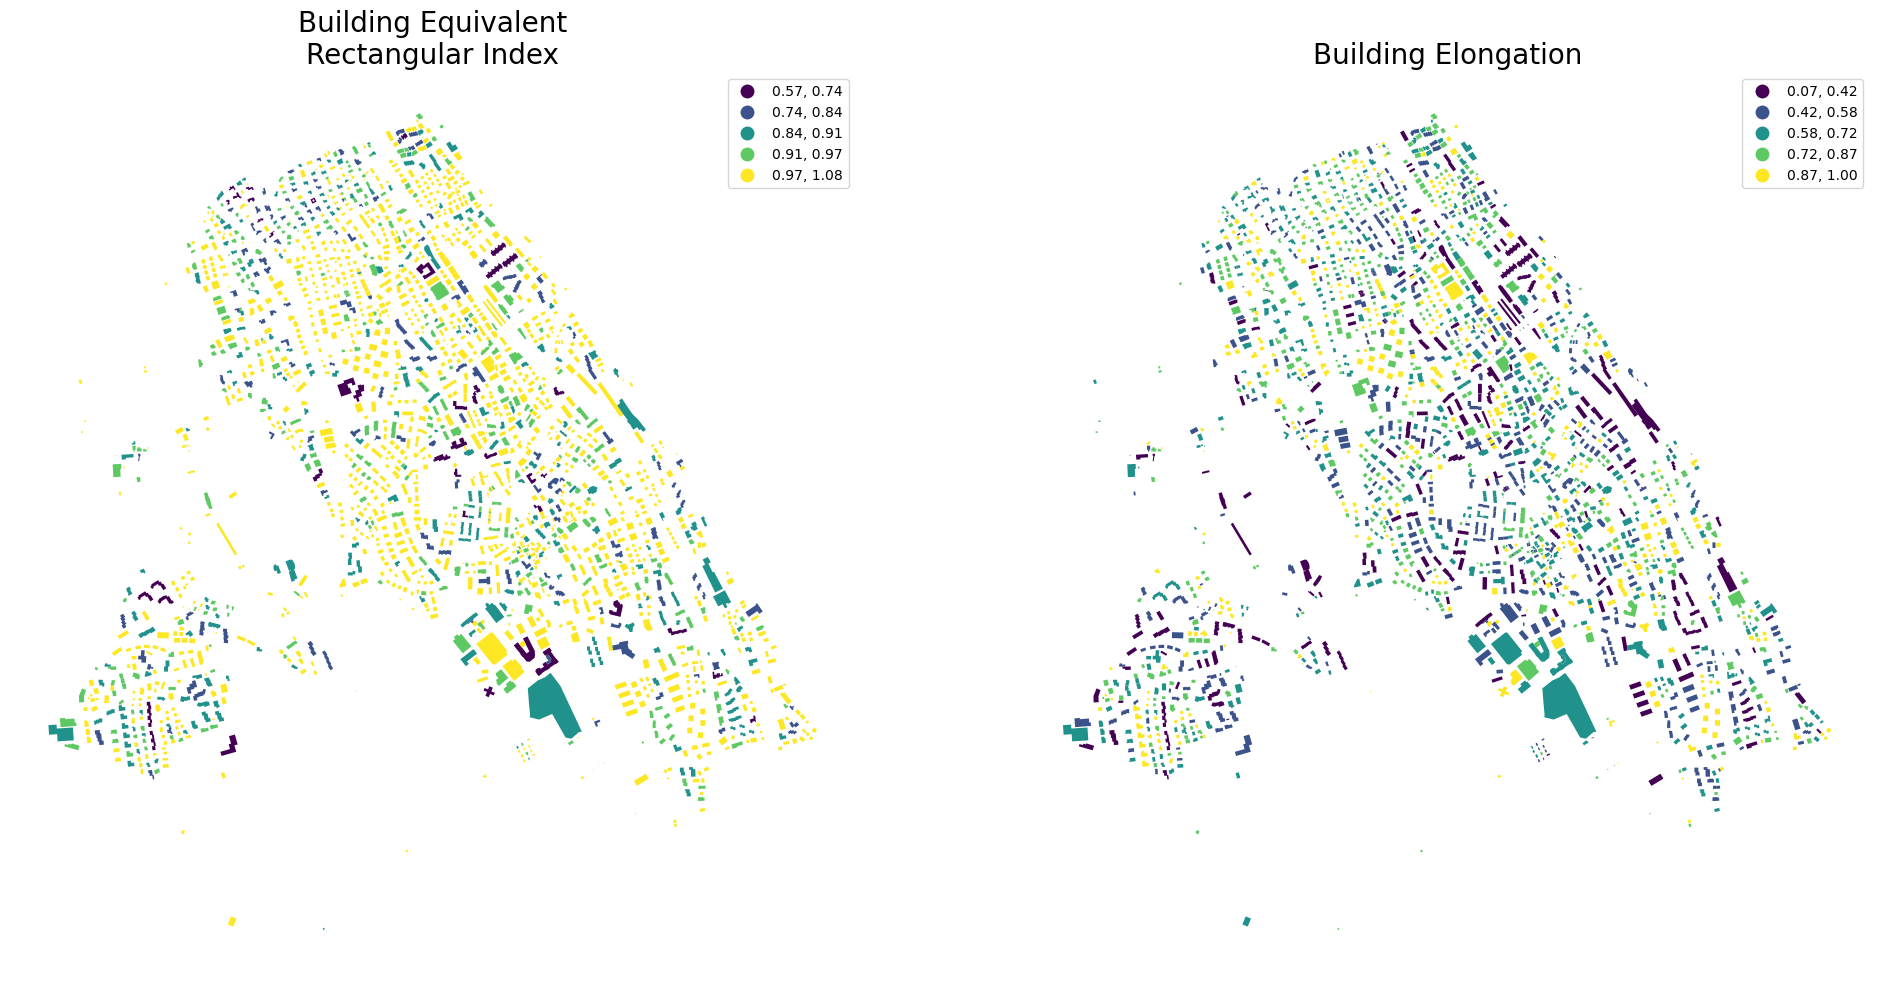

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Building Equivalent\nRectangular Index', fontsize=20)
ax[1].set_title('Building Elongation', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Thalwil/eri_and_elongation.svg')  

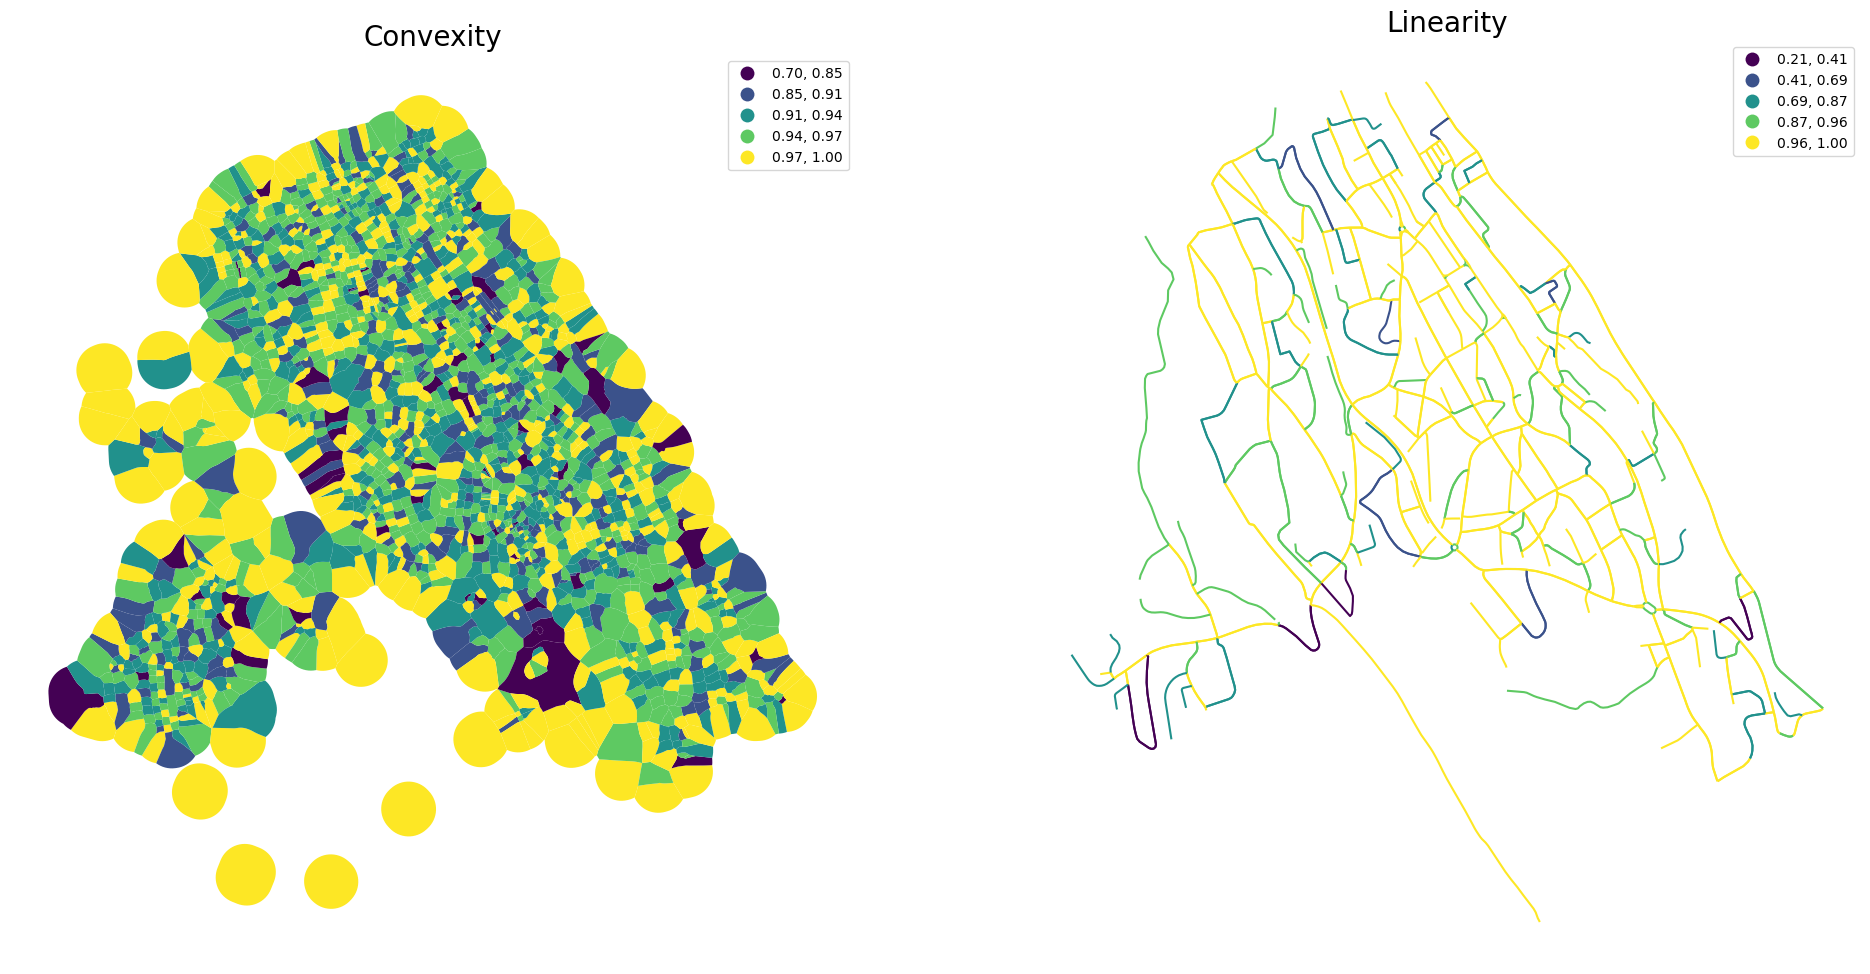

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Linearity', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Thalwil/convexity_and_linearity.svg')  

### Spatial distribution

In [34]:
buildings["shared_walls"] = momepy.SharedWallsRatio(buildings).series

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/momepy/distribution.py:214: FutureWarning: Class based API like `momepy.SharedWalls` or `momepy.SharedWallsRatio` is deprecated. Replace it with `momepy.shared_walls` or explicitly computing `momepy.shared_walls / gdf.length` respectively to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  super().__init__(gdf)


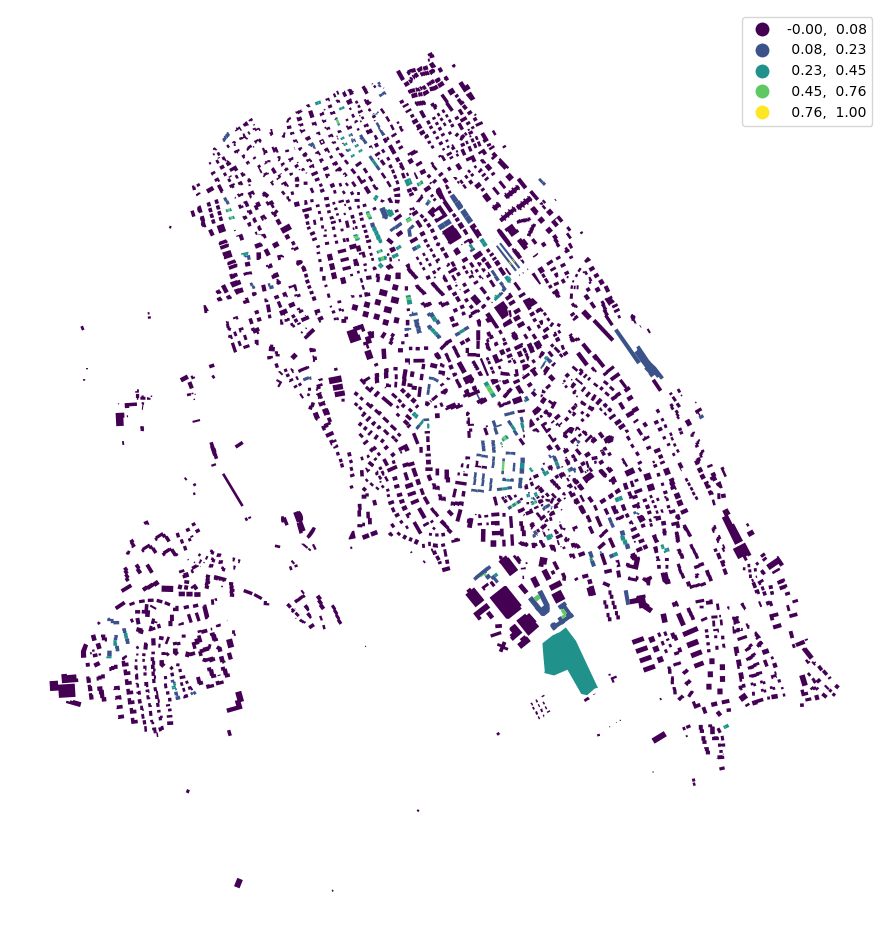

In [35]:
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

plt.savefig('../results/Thalwil/sharedwalls.svg')  

Generate spatial weights matrix using `libpysal`.

In [36]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [37]:
tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/1669107924.py:1: FutureWarning: Class based API like `momepy.Neighbors` is deprecated. Replace it with `momepy.neighbors` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/1669107924.py:2: FutureWarning: `momepy.CoveredArea` is deprecated. Replace it with `.describe()` method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series


In [38]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Neighbour Distance', fontsize=20)
ax[1].set_title('Covered Area', fontsize=20)


ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Thalwil/neighbourdist_and_coveredarea.svg')  

In [39]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = momepy.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['adjacency'] = momepy.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/3221532125.py:1: FutureWarning: `momepy.sw_high` is deprecated. Replace it with .higher_order() method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  queen_3 = momepy.sw_high(k=3, weights=queen_1)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/3221532125.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/3221532125.py:4: FutureWarning: Class based API like `momepy.MeanInterbuildingDistance` is deprecated. Replace it with `momepy.mean_interbuilding_distance` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['interbuilding_distance'] 

In [40]:
#fig, ax = plt.subplots(1, 2, figsize=(24, 12))
#
#buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
#buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)
#
#ax[0].set_axis_off()
#ax[1].set_axis_off()

In [41]:
profile = momepy.StreetProfile(streets, buildings)
streets["width"] = profile.w
streets["width_deviation"] = profile.wd
streets["openness"] = profile.o

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/2648127835.py:1: FutureWarning: Class based API like `momepy.StreetProfile` is deprecated. Replace it with `momepy.street_profile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  profile = momepy.StreetProfile(streets, buildings)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in intersection
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [42]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_title('Width', fontsize=20)
ax[1].set_title('Width Deviation', fontsize=20)
ax[2].set_title('Openness', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Thalwil/road_network.svg')  

### Intensity

In [43]:
tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/1819725789.py:1: FutureWarning: `momepy.AreaRatio` is deprecated. Replace it with a direct division of areas or momepy.describe_agg() or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series


In [44]:
tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()
plt.title("Building/Tessellation Area Ratio")

plt.savefig('../results/Thalwil/tessellation_ratio.svg')  

### Connectivity

In [45]:
graph = momepy.gdf_to_nx(streets)

In [46]:
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")

  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/339 [00:00<?, ?it/s]

In [47]:
nodes, streets = momepy.nx_to_gdf(graph)

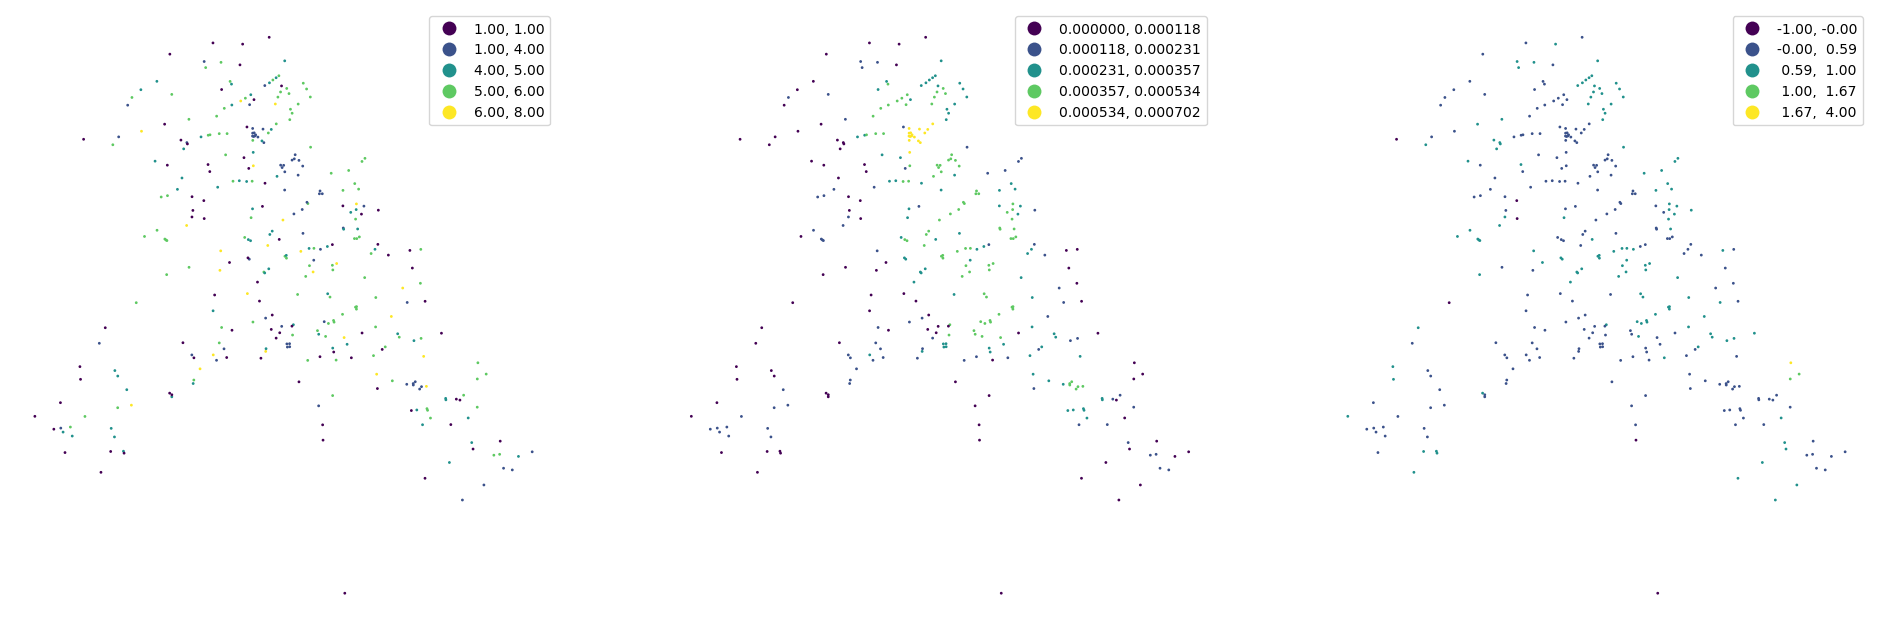

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot("degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1)
nodes.plot("closeness", ax=ax[1], scheme="natural_breaks", legend=True, markersize=1, legend_kwds={"fmt": "{:.6f}"})
nodes.plot("meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Thalwil/connectivity.svg')  

In [49]:
buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/403706460.py:1: FutureWarning: Class based API like `momepy.get_node_id` is deprecated. Replace it with `momepy.get_nearest_node` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")


  0%|          | 0/2251 [00:00<?, ?it/s]

Link all data together (to tessellation cells or buildings).

In [50]:
tessellation

uID                                           geometry  nID  \
0     2249  POLYGON ((2684324.961 1236771.424, 2684323.620...  656   
1     1437  POLYGON ((2683565.841 1237362.031, 2683579.664...  652   
2     1436  POLYGON ((2683538.796 1237542.695, 2683551.045...  648   
3     2036  POLYGON ((2683931.125 1237115.127, 2683934.372...  656   
4     1435  POLYGON ((2683741.867 1237351.739, 2683742.785...   27   
...    ...                                                ...  ...   
2246   852  POLYGON ((2684875.730 1239603.529, 2684875.723...  649   
2247  1672  POLYGON ((2684830.557 1239593.989, 2684830.273...  649   
2248  1668  POLYGON ((2684792.953 1239577.162, 2684792.808...  683   
2249  1473  POLYGON ((2684859.635 1239623.576, 2684858.361...  649   
2250  1472  POLYGON ((2684862.552 1239643.003, 2684857.737...  649   

              area  convexity  neighbors  covered_area       car  
0     42362.603352   1.000000   0.000000  42362.603352  0.015170  
1     16094.813420   0.979681   0.008150  61182.515539  0.046179  
2     27010.925540   0.844055   0.005615  56872.285467  0.135877  
3     36076.164324   1.000000   0.000000  36076.164324  0.003618  
4      9850.165544   0.977772   0.012877  40593.610389  0.028262  
...            ...        ...        ...           ...       ...  
2246    931.395332   0.923706   0.040173  21041.039545  0.346778  
2247   1162.416015   0.868899   0.037446  24454.651714  0.234187  
2248   3609.460458   0.946433   0.017970  34113.774357  0.126280  
2249    617.064907   0.980303   0.036607  19892.645603  0.112990  
2250  16627.983666   0.988243   0.014393  48214.188386  0.019098  

[2251 rows x 8 columns]

In [51]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

In [52]:
merged.columns

Index(['uID', 'geometry', 'nID', 'area_x', 'convexity', 'neighbors',
       'covered_area', 'car', 'area_y', 'eri', 'elongation', 'shared_walls',
       'neighbor_distance', 'interbuilding_distance', 'adjacency', 'nodeID',
       'length', 'linearity', 'width', 'width_deviation', 'openness', 'mm_len',
       'node_start', 'node_end', 'x', 'y', 'degree', 'closeness',
       'meshedness'],
      dtype='object')

## Understanding the context

Measure first, second and third quartile of distribution of values within an area around each building.

In [53]:
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42420/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API

In [54]:
percentiles_joined = pandas.concat(percentiles, axis=1)

In [55]:
percentiles_joined

area_x_25     area_x_50     area_x_75  convexity_25  convexity_50  \
0     42362.603352  42362.603352  42362.603352      1.000000      1.000000   
1      1360.851627   1755.340168   5604.055659      0.919018      0.946482   
2      1486.602197   2241.154441   5604.055659      0.922587      0.955773   
3     36076.164324  36076.164324  36076.164324      1.000000      1.000000   
4       851.670527   1589.074511   3984.999629      0.919018      0.954548   
...            ...           ...           ...           ...           ...   
2246    836.883351   1091.228543   1729.150684      0.928817      0.945313   
2247    760.927247   1019.288613   1656.076832      0.925921      0.942219   
2248    760.927247   1069.143089   1849.289186      0.925921      0.943507   
2249    767.714893   1047.057634   2638.685212      0.928365      0.944378   
2250    767.714893   1106.656598   2155.696971      0.925921      0.945313   

      convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0         1.000000      0.000000      0.000000      0.000000     42362.603352   
1         0.968178      0.017140      0.031133      0.041423     11532.770895   
2         0.969105      0.015531      0.030516      0.041813     18256.253932   
3         1.000000      0.000000      0.000000      0.000000     36076.164324   
4         0.968305      0.020585      0.036499      0.046178      9369.561895   
...            ...           ...           ...           ...              ...   
2246      0.964288      0.031212      0.038080      0.051666      8529.406577   
2247      0.962314      0.032146      0.040051      0.053227      6557.468504   
2248      0.968338      0.033371      0.040229      0.052435      7257.742249   
2249      0.968338      0.024755      0.038080      0.052021      7006.392001   
2250      0.969986      0.031376      0.039814      0.051835      8423.944346   

      ...          y_75  degree_25  degree_50  degree_75  closeness_25  \
0     ...  1.237310e+06        1.0        1.0        1.0      0.000019   
1     ...  1.237518e+06        1.0        5.0        5.0      0.000138   
2     ...  1.237545e+06        1.0        1.0        5.0      0.000087   
3     ...  1.237310e+06        1.0        1.0        1.0      0.000019   
4     ...  1.237507e+06        5.0        5.0        5.0      0.000147   
...   ...           ...        ...        ...        ...           ...   
2246  ...  1.239644e+06        1.0        1.0        5.0      0.000097   
2247  ...  1.239644e+06        1.0        2.5        5.0      0.000097   
2248  ...  1.239644e+06        1.0        1.0        5.0      0.000097   
2249  ...  1.239663e+06        1.0        1.0        5.0      0.000097   
2250  ...  1.239644e+06        1.0        1.0        5.0      0.000097   

      closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0         0.000019      0.000019       1.000000       1.000000       1.000000  
1         0.000147      0.000147       0.466667       0.466667       0.466667  
2         0.000138      0.000147       0.466667       0.466667       0.545455  
3         0.000019      0.000019       1.000000       1.000000       1.000000  
4         0.000147      0.000147       0.466667       0.466667       0.466667  
...            ...           ...            ...            ...            ...  
2246      0.000107      0.000235       0.523810       0.666667       0.857143  
2247      0.000171      0.000235       0.523810       0.690476       0.857143  
2248      0.000107      0.000235       0.523810       0.666667       0.780488  
2249      0.000107      0.000235       0.523810       0.666667       0.857143  
2250      0.000107      0.000235       0.523810       0.666667       0.857143  

[2251 rows x 66 columns]

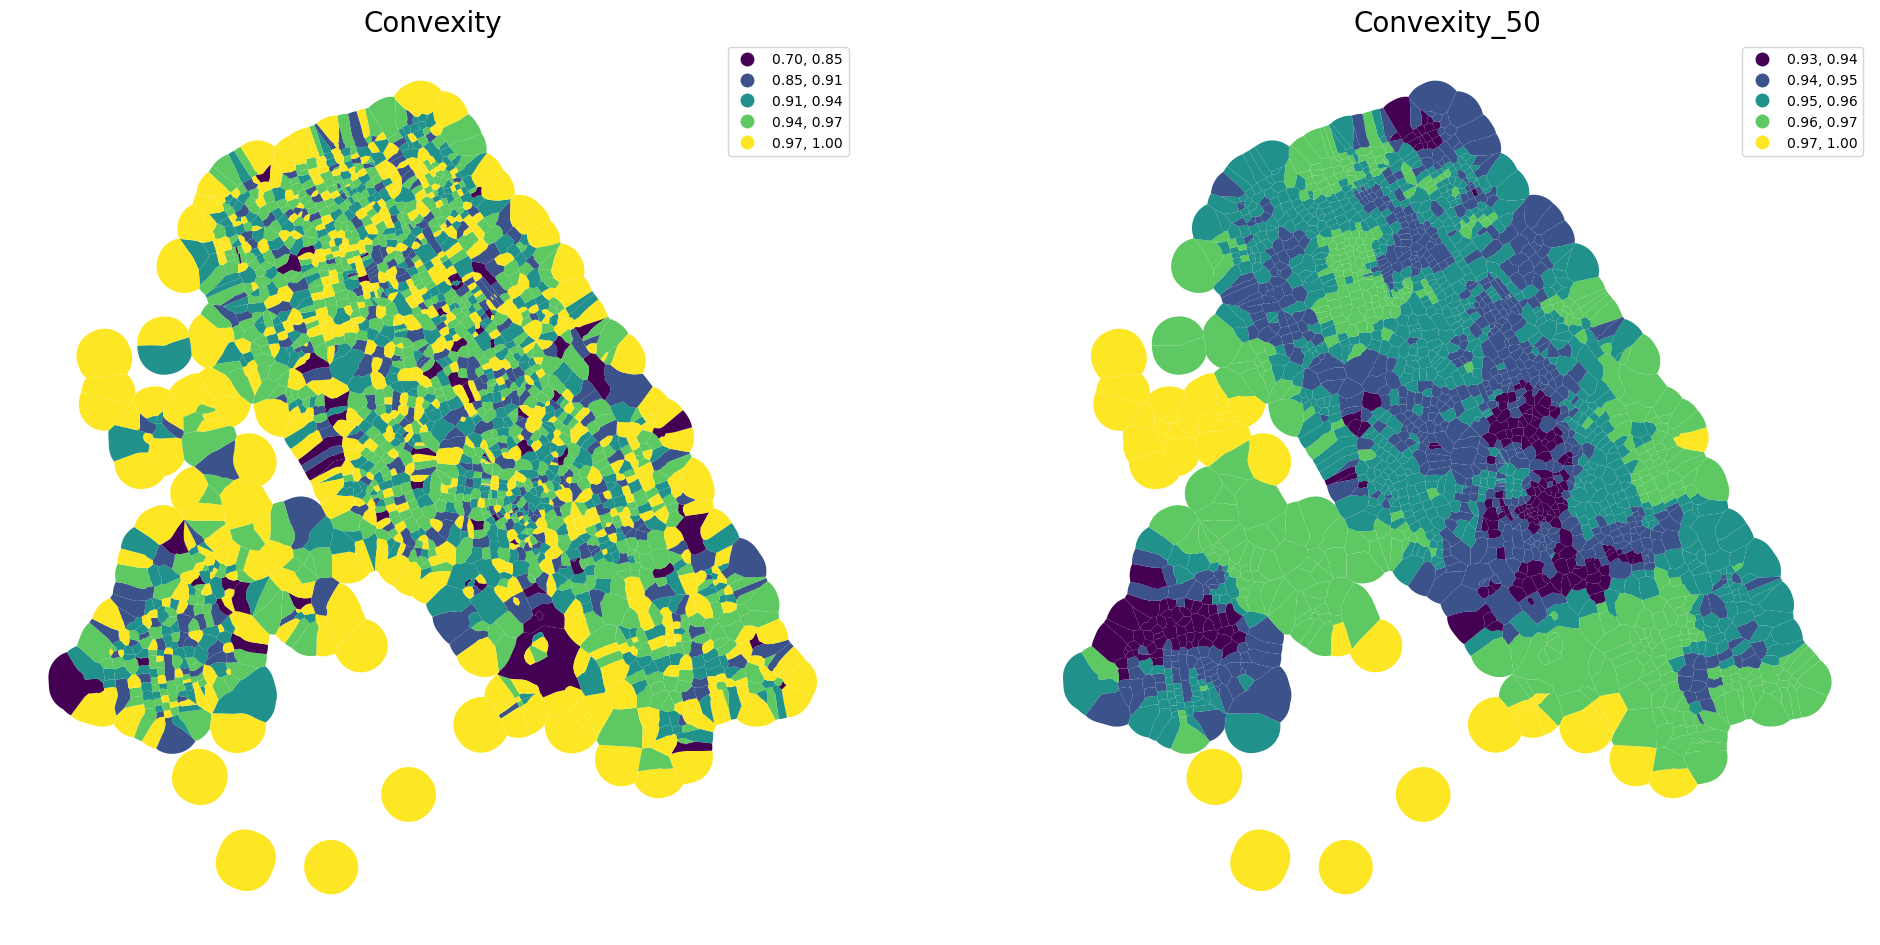

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(percentiles_joined['convexity_50'].values, ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Convexity_50', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Thalwil/convexity.svg')  

## Clustering

Standardize values before clustering.

In [57]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()

In [58]:
standardized

area_x_25  area_x_50  area_x_75  convexity_25  convexity_50  \
0     25.992409  22.052594  14.962230      5.984656      5.347081   
1      0.214018   0.100596   1.121421     -0.776339     -0.805095   
2      0.293079   0.363223   1.121421     -0.478349      0.262955   
3     22.040034  18.654189  12.595178      5.984656      5.347081   
4     -0.106112   0.010714   0.511793     -0.776339      0.122161   
...         ...        ...        ...           ...           ...   
2246  -0.115408  -0.258418  -0.337609      0.041732     -0.939511   
2247  -0.163163  -0.297309  -0.365124     -0.200007     -1.295179   
2248  -0.163163  -0.270358  -0.292373     -0.200007     -1.147162   
2249  -0.158896  -0.282297   0.004861      0.003986     -1.047038   
2250  -0.158896  -0.250078  -0.177000     -0.200007     -0.939511   

      convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0         4.089324     -3.290710     -4.031003     -4.403778         5.291416   
1        -0.600547     -1.598972     -0.986998     -0.718982         0.369986   
2        -0.463888     -1.757752     -1.047267     -0.684241         1.443269   
3         4.089324     -3.290710     -4.031003     -4.403778         4.287899   
4        -0.581828     -1.258923     -0.462357     -0.295952         0.024668   
...            ...           ...           ...           ...              ...   
2246     -1.173794     -0.209987     -0.307776      0.192256        -0.109448   
2247     -1.464739     -0.117759     -0.115013      0.331071        -0.424232   
2248     -0.576973      0.003112     -0.097630      0.260618        -0.312446   
2249     -0.576973     -0.847325     -0.307776      0.223785        -0.352570   
2250     -0.334113     -0.193797     -0.138247      0.207242        -0.126283   

      ...      y_75  degree_25  degree_50  degree_75  closeness_25  \
0     ... -1.992339  -2.053243  -4.155162  -5.710522     -1.414536   
1     ... -1.651405  -2.053243  -0.352633  -1.173947     -0.450629   
2     ... -1.607841  -2.053243  -4.155162  -1.173947     -0.863260   
3     ... -1.992339  -2.053243  -4.155162  -5.710522     -1.414536   
4     ... -1.669081   0.433628  -0.352633  -1.173947     -0.378619   
...   ...       ...        ...        ...        ...           ...   
2246  ...  1.824665  -2.053243  -4.155162  -1.173947     -0.781078   
2247  ...  1.824665  -2.053243  -2.729214  -1.173947     -0.781078   
2248  ...  1.824665  -2.053243  -4.155162  -1.173947     -0.781078   
2249  ...  1.855170  -2.053243  -4.155162  -1.173947     -0.781078   
2250  ...  1.824665  -2.053243  -4.155162  -1.173947     -0.781078   

      closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0        -1.662023     -1.896973       3.093635       2.081523       0.710820  
1        -0.712331     -0.994955      -0.329878      -0.555872      -0.478571  
2        -0.778348     -0.994955      -0.329878      -0.555872      -0.302866  
3        -1.662023     -1.896973       3.093635       2.081523       0.710820  
4        -0.712331     -0.994955      -0.329878      -0.555872      -0.478571  
...            ...           ...            ...            ...            ...  
2246     -1.007302     -0.374010       0.036927       0.433151       0.392233  
2247     -0.532935     -0.374010       0.036927       0.550892       0.392233  
2248     -1.007302     -0.374010       0.036927       0.433151       0.221284  
2249     -1.007302     -0.374010       0.036927       0.433151       0.392233  
2250     -1.007302     -0.374010       0.036927       0.433151       0.392233  

[2251 rows x 66 columns]

### How many clusters?

In [59]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=0)
cgram.fit(standardized.fillna(0))

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.086 seconds.
K=3 fitted in 0.033 seconds.
K=4 fitted in 0.047 seconds.
K=5 fitted in 0.061 seconds.
K=6 fitted in 0.112 seconds.
K=7 fitted in 0.063 seconds.
K=8 fitted in 0.058 seconds.
K=9 fitted in 0.064 seconds.
K=10 fitted in 0.077 seconds.
K=11 fitted in 0.077 seconds.


Clustergram(k_range=range(1, 12), backend='sklearn', method='kmeans', kwargs={'n_init': 10, 'random_state': 0})

In [60]:
show(cgram.bokeh())

In [61]:
cgram.labels.head()

1   2   3   4   5   6   7   8   9   10  11
0   0   1   2   2   3   1   3   6   8   8   8
1   0   1   0   3   1   2   2   1   4   9  10
2   0   1   0   3   1   2   2   0   4   5   7
3   0   1   2   2   3   1   3   6   8   8   8
4   0   1   0   3   1   2   2   1   4   9  10

In [62]:
merged["cluster"] = cgram.labels[8].values

In [63]:
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")

In [64]:
urban_types.explore("cluster", categorical=True, prefer_canvas=True, tiles="CartoDB Positron", tooltip=False)

## Export

Save cluster output geodata to geojson file:

In [65]:
urban_types.to_file('../data/raw/Thalwil.geojson', driver='GeoJSON')

## Utilities

Once you run the cell below, it hides all cells below the currently active one (aka presentation mode).

In [ ]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: none;
}
</style>

Run this cell to turn the presentation mode off.

In [ ]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: block;
}
</style>